#  Evaluation of the Perceptron Learner

In [15]:
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

## Load `digits` dataset

In [16]:
data = np.char.encode(np.loadtxt("/Users/ryanqchiqache/PycharmProjects/Machine-Learning-Learning-Center/learningML/data/digits.text", dtype=str), "ascii") # Read data as array of ASCII strings
data = (data.view("S1") == b'1').astype(np.int8).reshape((-1, 1024)) # Convert strings into 8-bit integer arrays
classes = np.array([0,1,8])
y = np.repeat(classes.reshape((-1,1)), 50, axis=-1).reshape(-1) # Array of 50 "0", 50 "1"s and 50 "8"s..

Plot of 6 example data points (images) and labels from the dataset:


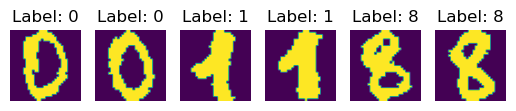

In [5]:
def plot_images(data, ys, pred_ys=None):
  l = len(data)
  fig, axs = plt.subplots(ncols=l)
  if l == 1:
    axs = [axs]
  if pred_ys is None:
    pred_ys = [None] * l
  for ax, img, y, pred_y in zip(axs, data, ys, pred_ys):
    ax.imshow(img.reshape((32,32)))
    ax.axis("off")
    if pred_y is None:
      ax.title.set_text(f"Label: {y}")
    else:
      ax.title.set_text(f"Label: {y} / Prediction: {pred_y}")
    
  plt.show()

print("Plot of 6 example data points (images) and labels from the dataset:")
example_instances = [0, 10, 50, 60, 100, 110]
plot_images(data[example_instances], y[example_instances])

## Partition the dataset for LOO-CV

For Leave-one-out Cross Validation, we partition the dataset into 150 train/test splits.
Each instance (i.e., image) is used exactly once as a test instance, while the respective remaining instances are used for training.

In [6]:
def train_test_split(data, y, idx):
  train_data = np.delete(data, [idx], axis=0)
  train_y = np.delete(y, [idx])
  test_data = data[[idx]]
  test_y = y[[idx]]
  return train_data, train_y, test_data, test_y

cv_partitions = [train_test_split(data, y, idx) for idx in range(data.shape[0])]

`cv_partitions` is a list of 150 train/test splits of the `digits` dataset.
Each split is represented as a 4-tuple `(train_data, train_y, test_data, test_y)` containing the training instances + target values and the respective test instance + target value.

## Training of a `Perceptron` model using scikit-learn

In [7]:
def train_perceptron_model(train_data: np.ndarray, train_y: np.ndarray) -> lm.Perceptron:
  model = lm.Perceptron()
  model.fit(train_data, train_y)
  return model

You can use the `train_perceptron_model` function to train a Perceptron model using the PLA algorithm.
- For the one-vs-rest setting, you can obtain the real-valued confidence score for a given test instance by calling `model.decision_function(test_data)`.
- For the one-vs-one setting, you can obtain a binary prediction for a given test instance by calling `model.predict(test_data)`. 

## 1. Evaluation of the One-vs-Rest Approach

We begin by evaluating the one-vs-rest approach.
For this we have to train three binary classifiers, that are trained to solve the following three classification problems:
- `0` vs `{1,8}`
- `1` vs `{0,8}`
- `8` vs `{0,1}`

To train Perceptron models for those three classification tasks, we have to transform our multi-class `digits` dataset into three binary classification datasets.
The `multiclass_to_ovr` function shows how this transformation can be done.

In [8]:
def multiclass_to_ovr(train_data, train_y, cls):
  return train_data, train_y == cls

def train_ovr_perceptron_model(train_data, train_y, classes):
  models = {
    cls: train_perceptron_model(*multiclass_to_ovr(train_data, train_y, cls))
    for cls in classes
  }
  
  def predict(test_data: np.ndarray):
    predictions = []
    # Iterate over test_instances:
    for instance in test_data: # CHALLENGE: Vectorize this loop.
      max_confidence = np.NINF # negative infinity
      max_cls = None
      for cls, model in models.items():
        confidence = model.decision_function([instance])[0]
        if confidence > max_confidence:
          max_confidence = confidence
          max_cls = cls
      predictions.append(max_cls)
    return np.array(predictions)
  
  return predict

The `train_ovr_perceptron_model` function calls the `multiclass_to_ovr` preprocessing function once for each class (`0`, `1`, `8`) and trains a Perceptron model using the `train_perceptron_model` defined above.
It returns a function that takes an array of training instances and returns an array containing the classes with the highest confidence for each training instance.

To show how `train_ovr_perceptron_model` is used, we now apply it to the first of the 150 LOO-CV train/test splits:

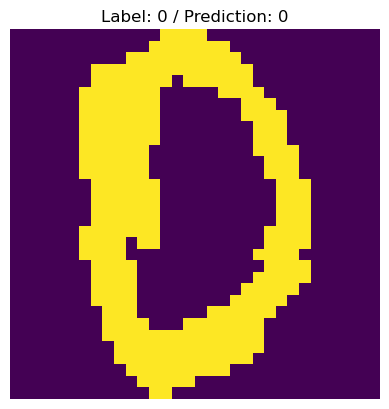

In [9]:
first_train_data, first_train_y, first_test_data, first_test_y = cv_partitions[0]

predictor = train_ovr_perceptron_model(first_train_data, first_train_y, classes)
first_test_pred_y = predictor(first_test_data)
plot_images(first_test_data, first_test_y, first_test_pred_y)

**Task:** Use the OvR approach to train a multiclass prediction model for all 150 LOO-CV partitions and count the total number of errors.

The OvR approach results in 4 errors : 


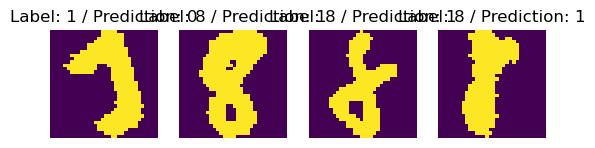

In [10]:
import numpy as np

def loo_cv_eval(train_model, cv_partitions, classes):
    errors = 0
    error_data, error_pred, error_y = [], [], []

    for partition in cv_partitions:
        train_data, train_y, test_data, test_y = partition
        predictor = train_model(train_data, train_y, classes)
        test_pred_y = predictor(test_data)

        error_mask = test_pred_y != test_y
        errors += np.sum(error_mask)
        error_data.extend(test_data[error_mask])  
        error_pred.extend(test_pred_y[error_mask])  
        error_y.extend(test_y[error_mask]) 
    return errors, error_data, error_pred, error_y

errors, error_data, error_pred, error_y = loo_cv_eval(train_ovr_perceptron_model, cv_partitions, classes)

print(f"The OvR approach results in {errors} errors : ")
plot_images(error_data, error_y, error_pred)

## 2. Evaluation of the One-vs-One Approach

Next, we evaluate the one-vs-one approach. For this we have to train a binary classifier for each pair of classes:
- `0` vs `1`
- `0` vs `8`
- `1` vs `8`

As we have already seen with the one-vs-rest approach, we again have to preprocess the dataset and turn it into three binary classification datasets for training.

In [11]:
def multiclass_to_ovo(train_data, train_y, cls_a, cls_b):
  mask = (train_y == cls_a) | (train_y == cls_b) # Boolean mask marking all instances that have class a or class b.
  masked_data = train_data[mask]
  masked_y = train_y[mask] == cls_a
  return masked_data, masked_y

The `multiclass_to_ovo` function transforms the given instances and labels into a binary classification task for the classes `cls_a` and `cls_b`.
Instances that are of neither `cls_a` nor `cls_b` are removed.

**Task:** Use this preprocessing function to train a OvO each LOO-CV partition.

In [12]:
def train_ovo_perceptron_model(train_data, train_y, classes):
    models = {
        (a,b) : train_perceptron_model(*multiclass_to_ovo(train_data, train_y,classes[a],classes[b]))
        
        for a in range(len(classes))
        for b in range(a +1 ,len(classes))
    }
    
    def predict(test_data: np.ndarray):
        votes = np.zeros((len(test_data), len(classes)) , dtype= np.float32)
        idxs = np.arrange(len(test_data))
        for (a,b), m in models.items():
            pred = m.predict(test_data)
            vote_idxs = np.where(pred , a, b)
            votes[idxs,vote_idxs] += np.abs(m.decision_function(test_data)[0])
        pred_idxs = np.argmax(votes, axis = -1)
        pred_classes = classes[pred_idxs]
        return pred_classes
    
    return predict
            

The Ov0 approach results in 4 errors : 


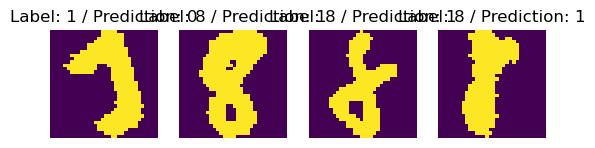

In [13]:
errors, error_data,error_pred, error_y = loo_cv_eval(train_ovr_perceptron_model, cv_partitions, classes)
print(f"The Ov0 approach results in {errors} errors : ")
plot_images(error_data, error_y, error_pred)

In [14]:
import itertools

# Define the relation R0
R0 = {(2,1), (3,1), (4,2), (5,1), (6,2), (6,3), (7,1), (8,4), (9,3), (10,2), (10,5)}

# Extract all unique elements from the relation
elements = set()
for a, b in R0:
    elements.add(a)
    elements.add(b)
elements = list(elements)  # Convert set to list for permutation generation

# Function to check if a permutation is a valid linear extension
def is_valid_extension(permutation):
    for (a, b) in R0:
        if permutation.index(a) > permutation.index(b):
            return False
    return True

# Generate all permutations of the elements
all_permutations = itertools.permutations(elements)

# Filter out the valid linear extensions
valid_extensions = []
for perm in all_permutations:
    if is_valid_extension(perm):
        valid_extensions.append(perm)
        if len(valid_extensions) == 2:  # Optionally limit to first two valid extensions for efficiency
            break

# Output the valid linear extensions
print("Valid Linear Extensions:")
for extension in valid_extensions:
    print(extension)

Valid Linear Extensions:
(6, 7, 8, 4, 9, 3, 10, 2, 5, 1)
(6, 7, 8, 4, 9, 3, 10, 5, 2, 1)
